In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
from pandarallel import pandarallel
import multiprocessing
import numpy as np
import os
from collections import Counter, defaultdict
import itertools
import sys 
sys.path.append("..") 

%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

In [3]:
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

In [4]:
model = p2v.P2V()

2023-10-25 15:24:41 -- start loading Mag_venue_info_df
2023-10-25 15:24:41 -- finish.
2023-10-25 15:24:41 -- start loading labeled_journal_info_df
2023-10-25 15:24:41 -- finish.


# 1 Using cosine similairty as the measurement

# 1.1 Use the last decade as the reference

In [8]:
ref_start_year = 2010
ref_end_year = 2021

start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']

self_dist_df = pd.DataFrame(columns=['VID'])
for i in range(0, 7):
    tar_start_year = start_year_list[i]
    tar_end_year = end_year_list[i]
    print("-----------------------")
    prinT("start comparing {start_year}-{end_year} with the reference decade".format(start_year=tar_start_year, end_year=tar_end_year))

    tar_wv = model.load_wv(tar_start_year, tar_end_year, 100, 10)
    ref_wv = model.load_wv(ref_start_year, ref_end_year, 100, 10)
    
    tar_VIDs = tar_wv.index_to_key
    ref_VIDs = ref_wv.index_to_key
    shared_VIDs = list(set(tar_VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    tar_idx = [tar_wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]
    
    tar_vectors = tar_wv.get_normed_vectors()[tar_idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]
    
    prinT("start aligning...")
    R, sca = orthogonal_procrustes(tar_vectors, ref_vectors)
    aligned_tar_vectors = np.dot(tar_vectors, R)
    prinT("finish. start compute cosine distance...")
    # cs = np.diagonal(cosine_similarity(aligned_tar_vectors, ref_vectors))
    dist =  paired_distances(aligned_tar_vectors, ref_vectors, metric='cosine')
    prinT("finish")

    tar_dist_df = pd.DataFrame({'VID': shared_VIDs,
                              'self_distance_'+tar_start_year+'s': dist})
    self_dist_df = self_dist_df.merge(tar_dist_df,
                        on='VID',
                        how='outer')
self_dist_df.loc[:,'venue_name'] = self_dist_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
self_dist_df['scopus_label'] = self_dist_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

-----------------------
2023-10-25 15:23:42 -- start comparing 1950-1959 with the reference decade
2023-10-25 15:23:42 -- start loading word vectors...
2023-10-25 15:23:42 -- word vectors loaded, and its shape is: (1645, 100)
2023-10-25 15:23:42 -- start loading word vectors...
2023-10-25 15:23:42 -- word vectors loaded, and its shape is: (37594, 100)
2023-10-25 15:23:42 -- the number of shared VIDs between this two decades: 1202
2023-10-25 15:23:42 -- start aligning...
2023-10-25 15:23:42 -- finish. start compute cosine distance...
2023-10-25 15:23:42 -- finish
-----------------------
2023-10-25 15:23:42 -- start comparing 1960-1969 with the reference decade
2023-10-25 15:23:42 -- start loading word vectors...
2023-10-25 15:23:42 -- word vectors loaded, and its shape is: (3116, 100)
2023-10-25 15:23:42 -- start loading word vectors...
2023-10-25 15:23:42 -- word vectors loaded, and its shape is: (37594, 100)
2023-10-25 15:23:42 -- the number of shared VIDs between this two decades: 23

# 1.2. Calculate cosine change between every decade and its previous decade

In [6]:
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']

cs_df = pd.DataFrame(columns=['VID'])
for i in range(1, 7):
    tar_start_year = start_year_list[i]
    tar_end_year = end_year_list[i]
    ref_start_year = start_year_list[i-1]
    ref_end_year = end_year_list[i-1]
    print("-----------------------")
    prinT("start comparing {start_year}-{end_year} with the reference decade".format(start_year=tar_start_year, end_year=tar_end_year))

    tar_wv = model.load_wv(tar_start_year, tar_end_year, 100, 10)
    ref_wv = model.load_wv(ref_start_year, ref_end_year, 100, 10)
    
    tar_VIDs = tar_wv.index_to_key
    ref_VIDs = ref_wv.index_to_key
    shared_VIDs = list(set(tar_VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    tar_idx = [tar_wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]
    
    tar_vectors = tar_wv.get_normed_vectors()[tar_idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]
    
    prinT("start aligning...")
    R, sca = orthogonal_procrustes(tar_vectors, ref_vectors)
    aligned_tar_vectors = np.dot(tar_vectors, R)
    prinT("finish. start compute cosine change...")
    cs = np.diagonal(cosine_similarity(aligned_tar_vectors, ref_vectors))
    prinT("finish")

    tar_cs_df = pd.DataFrame({'VID': shared_VIDs,
                              'cosine_similarity_'+tar_start_year+'s': cs})
    cs_df = cs_df.merge(tar_cs_df,
                        on='VID',
                        how='outer')
cs_df.loc[:,'venue_name'] = cs_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
cs_df['scopus_label'] = cs_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

-----------------------
2023-08-07 11:36:08 -- start comparing 1960-1969 with the reference decade
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (3186, 100)
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (1683, 100)
2023-08-07 11:36:08 -- the number of shared VIDs between this two decades: 1530
2023-08-07 11:36:08 -- start aligning...
2023-08-07 11:36:08 -- finish. start compute cosine similarity...
2023-08-07 11:36:08 -- finish
-----------------------
2023-08-07 11:36:08 -- start comparing 1970-1979 with the reference decade
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (5761, 100)
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (3186, 100)
2023-08-07 11:36:08 -- the number of shared VIDs between this two decades: 28

In [321]:
cs_df

,VID,cosine_similarity_1950s,cosine_similarity_1960s,cosine_similarity_1970s,cosine_similarity_1980s,cosine_similarity_1990s,cosine_similarity_2000s,venue_name,scopus_label
0,1.479803e+08,0.536453,NaN,NaN,0.466951,0.386582,0.759120,Bulletin De L Academie Nationale De Medecine,Medicine
1,2.785285e+06,0.694030,0.746864,0.743407,0.810143,0.766487,0.821322,The Journal of Comparative Neurology,Neuroscience
2,1.241662e+08,0.657591,0.641123,0.672203,0.579373,0.709564,0.707039,Quarterly Journal of Mechanics and Applied Mathematics,Mathematics
3,2.756444e+09,0.607243,0.606009,0.473114,0.496372,0.442619,0.261401,Advances in internal medicine,NaN
4,1.709670e+08,0.527496,0.429602,0.612468,0.744073,0.726447,0.807329,American Journal of Epidemiology,Medicine
...,...,...,...,...,...,...,...,...,...
24654,2.764439e+09,NaN,NaN,NaN,NaN,NaN,0.719071,Bulgarian Journal of Veterinary Medicine,Veterinary
24655,2.898526e+09,NaN,NaN,NaN,NaN,NaN,0.664372,EMC - AKOS - Trattato di Medicina,NaN
24656,2.010644e+08,NaN,NaN,NaN,NaN,NaN,0.824514,European Journal of Preventive Cardiology,Medicine
24657,1.125908e+08,NaN,NaN,NaN,NaN,NaN,0.726251,Journal of Transport and Land Use,Social Sciences


In [14]:
cs_df['mean_cosine_similarity'] = cs_df.drop(['VID'], axis = 1).mean(axis=1, numeric_only=True)

In [18]:
cs_df[~(cs_df['cosine_similarity_1960s'].isna() | cs_df['scopus_label'].isna())].sort_values(by='mean_cosine_similarity').head(5)

,VID,cosine_similarity_1960s,cosine_similarity_1970s,cosine_similarity_1980s,cosine_similarity_1990s,cosine_similarity_2000s,cosine_similarity_2010s,venue_name,scopus_label,mean_cosine_similarity
1272,203291325.0,0.386589,0.259798,0.475639,0.464099,0.481302,0.321417,American Scientist,Multidisciplinary,0.398140
54,65315170.0,0.386006,0.423142,0.343308,0.434169,0.374105,0.516077,Endeavour,Arts and Humanities,0.412801
17,169320561.0,0.453169,0.571671,0.450756,0.534741,0.322900,0.350789,Scientia Forestalis,Agricultural and Biological Sciences,0.447338
141,196862746.0,0.499373,0.508247,0.475523,0.420283,0.373590,0.439096,Biographical Memoirs of Fellows of the Royal Society,Medicine,0.452685
282,4310451.0,0.433791,0.462982,0.544392,0.382973,0.556032,0.606499,Homeopathy,Medicine,0.497778


In [104]:
cs_df[~cs_df['scopus_label'].isna()].sort_values(by=['cosine_similarity_1960s']).head(20)[['venue_name','scopus_label']]

,venue_name,scopus_label
54,Endeavour,Arts and Humanities
1272,American Scientist,Multidisciplinary
1383,Studies in Conservation,Arts and Humanities
282,Homeopathy,Medicine
17,Scientia Forestalis,Agricultural and Biological Sciences
665,Perspectives in Biology and Medicine,Medicine
788,Annual Review of Physiology,"Biochemistry, Genetics and Molecular Biology"
141,Biographical Memoirs of Fellows of the Royal Society,Medicine
184,Bulletin of Mathematical Biology,"Biochemistry, Genetics and Molecular Biology"
1020,Journal of The Franklin Institute-engineering and Applied Mathematics,Engineering


In [12]:
pd.wide_to_long(cs_df,
                stubnames=['cosine_similarity'],
                suffix='.+',
                sep='_',
                i = ['VID', 'venue_name', 'scopus_label'],
                j = 'decade')

cosine_similarity
VID          venue_name                                             scopus_label decade                      
1.479803e+08 Bulletin De L Academie Nationale De Medecine           Medicine     1950-1959           0.536453
                                                                                 1960-1969                NaN
                                                                                 1970-1979                NaN
                                                                                 1980-1989           0.466951
                                                                                 1990-1999           0.386582
...                                                                                                       ...
2.898264e+09 international conference service robotics technologies NaN          1970-1979                NaN
                                                                                 1980-1989                NaN
                                                                                 1990-1999                NaN
                                                                                 2000-2009                NaN
                                                                                 2010-2021           1.000000

[263753 rows x 1 columns]

<Figure size 1800x1200 with 0 Axes>

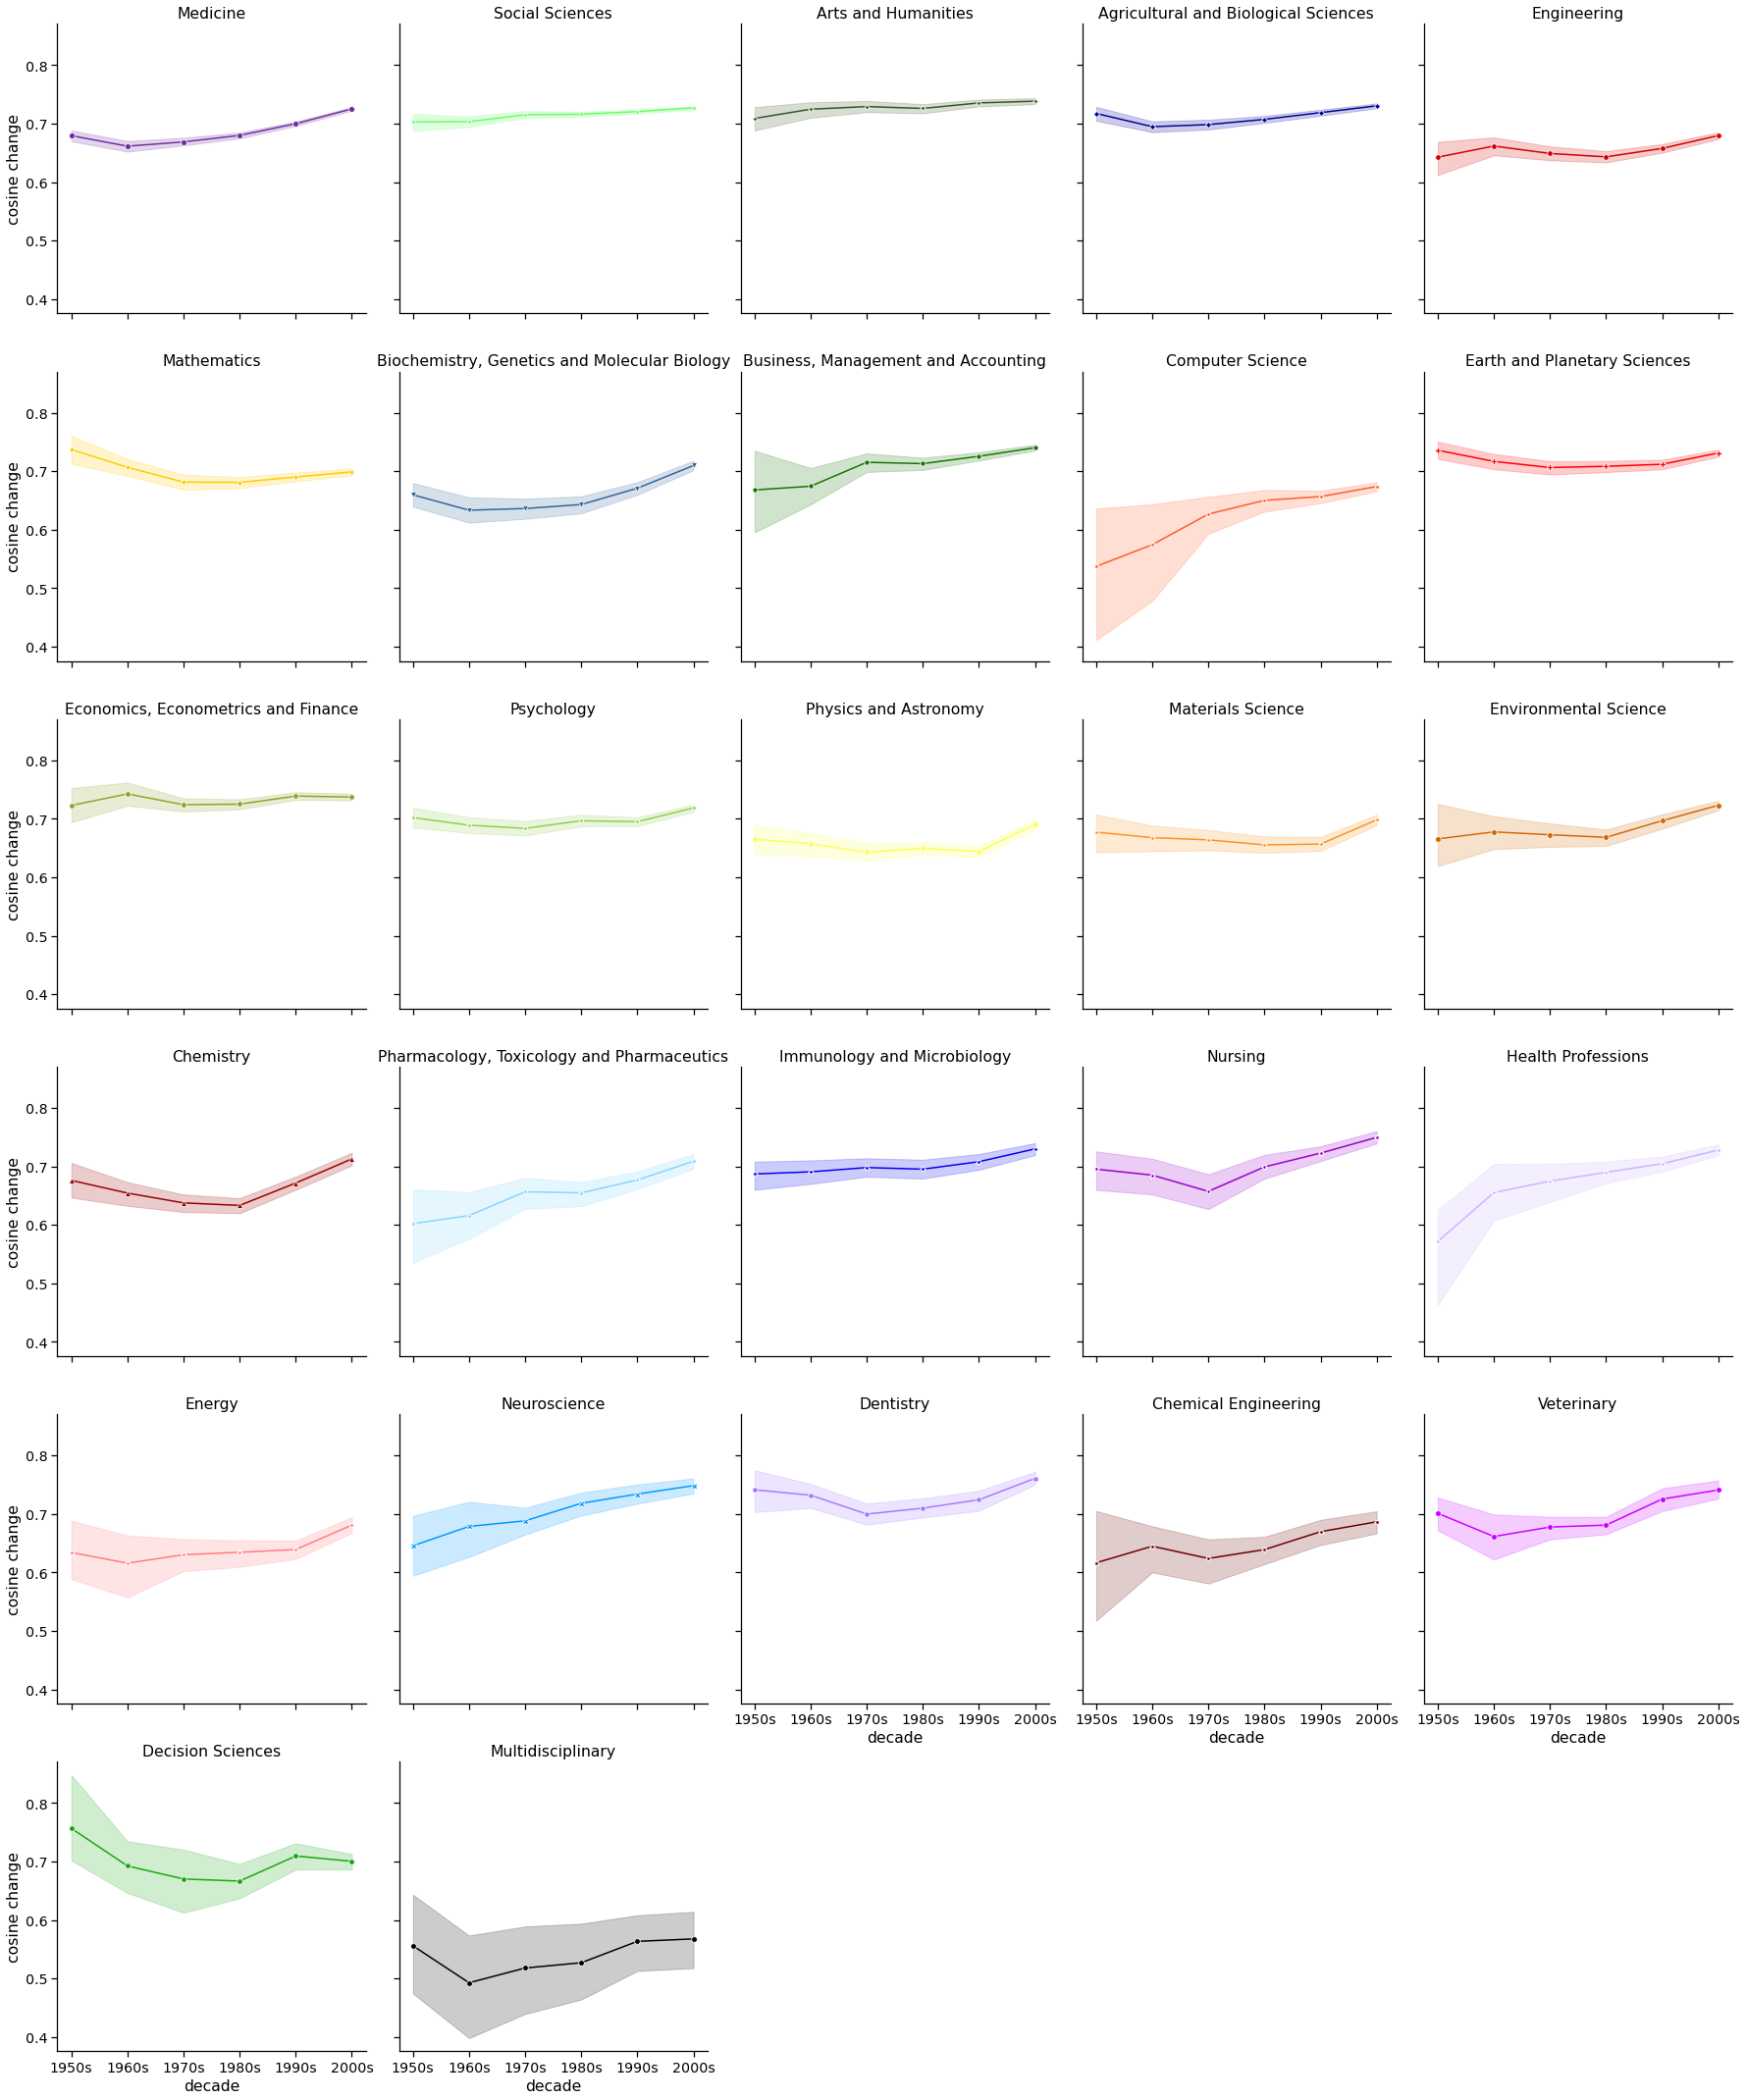

In [322]:
cs_df_wide = pd.wide_to_long(cs_df,
                             stubnames=['cosine_similarity'],
                             suffix='.+',
                             sep='_',
                             i = ['VID', 'venue_name'],
                             j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    ax = sns.relplot(data=cs_df_wide,
                     x='decade', y='cosine_similarity',
                     markers=True, dashes=False, style='scopus_label', hue='scopus_label', palette=model.discipline2color,
                     legend=False,
                     col='scopus_label', col_wrap=5, 
                     col_order=['Medicine', 'Social Sciences', 'Arts and Humanities',
                                'Agricultural and Biological Sciences', 'Engineering', 'Mathematics',
                                'Biochemistry, Genetics and Molecular Biology',
                                'Business, Management and Accounting', 'Computer Science',
                                'Earth and Planetary Sciences', 'Economics, Econometrics and Finance',
                                'Psychology', 'Physics and Astronomy', 'Materials Science',
                                'Environmental Science', 'Chemistry',
                                'Pharmacology, Toxicology and Pharmaceutics',
                                'Immunology and Microbiology', 'Nursing', 'Health Professions',
                                'Energy', 'Neuroscience', 'Dentistry', 'Chemical Engineering',
                                'Veterinary', 'Decision Sciences', 'Multidisciplinary'],
                     kind='line')
    ax.set_titles("{col_name}")
    ax.set_ylabels('cosine change')
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
ax.savefig('/media/sdb/p2v/figs/28_discipline_semantic_change.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# 2. Using local neighborhood measure

In [5]:
def get_tar_avg_neighbor_sim(VID):
    neighbor_sim_list = [tup[1] for tup in tar_wv.most_similar(positive=int(VID), topn=k_list[i])]
    return sum(neighbor_sim_list) / len(neighbor_sim_list)

def get_ref_avg_neighbor_sim(VID):
    neighbor_sim_list = [tup[1] for tup in ref_wv.most_similar(positive=int(VID), topn=k_list[i])]
    return sum(neighbor_sim_list) / len(neighbor_sim_list)

def cal_distance(x):
    neighbor_idx_list = list(set(tar_neighbor_idxs[x]).union(set(ref_neighbor_idxs[x])))
    # tar_neighbor_vectors = [aligned_tar_vectors[idx] for idx in neighbor_idx_list]
    tar_neighbor_vectors = [tar_vectors[idx] for idx in neighbor_idx_list]
    ref_neighbor_vectors = [ref_vectors[idx] for idx in neighbor_idx_list]
    # tar_focal_vector = aligned_tar_vectors[x]
    tar_focal_vector = tar_vectors[x]
    ref_focal_vector = ref_vectors[x]

    tar_second_order_change = cosine_similarity(tar_focal_vector.reshape(1,-1), tar_neighbor_vectors)
    ref_second_order_change = cosine_similarity(ref_focal_vector.reshape(1,-1), ref_neighbor_vectors)

    return paired_distances(tar_second_order_change, ref_second_order_change, metric='cosine')[0]

In [53]:
k_list = [8, 8, 13, 25, 19, 18, 23]
# k_list = [25, 25, 25, 25, 25, 25]

start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']
ref_start_year = 2010
ref_end_year = 2021

neighbor_dist_df = pd.DataFrame(columns=['VID'])
pandarallel.initialize()
for i in range(0, 7):
    tar_start_year = start_year_list[i]
    tar_end_year = end_year_list[i]
    print("-----------------------")
    prinT("start comparing {start_year}-{end_year} with the reference decade".format(start_year=tar_start_year, end_year=tar_end_year))
    
    tar_wv = model.load_wv(tar_start_year, tar_end_year, 100, 10)
    ref_wv = model.load_wv(ref_start_year, ref_end_year, 100, 10)
    
    tar_VIDs = tar_wv.index_to_key
    ref_VIDs = ref_wv.index_to_key
    
    shared_VIDs = list(set(tar_VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))

    # prinT("start filter those periodicals with low neighborhood similarity...")
    # avg_neighbor_sim_df = pd.DataFrame({'VID':shared_VIDs})
    # avg_neighbor_sim_df['tar_avg_neighbor_sim'] = avg_neighbor_sim_df.VID.parallel_apply(get_tar_avg_neighbor_sim)
    # avg_neighbor_sim_df['ref_avg_neighbor_sim'] = avg_neighbor_sim_df.VID.parallel_apply(get_ref_avg_neighbor_sim)
    # shared_VIDs = avg_neighbor_sim_df[(avg_neighbor_sim_df.tar_avg_neighbor_sim >= avg_neighbor_sim_df.tar_avg_neighbor_sim.quantile(0.25)) & 
    #                                   (avg_neighbor_sim_df.ref_avg_neighbor_sim >= avg_neighbor_sim_df.ref_avg_neighbor_sim.quantile(0.25))].VID.tolist()
    
    tar_idx = [tar_wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]
    
    tar_vectors = tar_wv.get_normed_vectors()[tar_idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]
    
    prinT("finish, start generate neighbor union...")
    tar_neighbor_idxs = np.argsort(cosine_similarity(tar_vectors, tar_vectors))[:, -2:-k_list[i]-2:-1]
    ref_neighbor_idxs = np.argsort(cosine_similarity(ref_vectors, ref_vectors))[:, -2:-k_list[-1]-2:-1]
    
    prinT("finish, start calculating local neighborhood change...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    dist_df['neighbor_distance_'+tar_start_year+'s'] = dist_df.index.to_series().parallel_apply(cal_distance)
    prinT('finish.')

    neighbor_dist_df = neighbor_dist_df.merge(dist_df, on='VID', how='outer')
    
neighbor_dist_df.loc[:,'venue_name'] = neighbor_dist_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
neighbor_dist_df['scopus_label'] = neighbor_dist_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
-----------------------
2023-10-25 16:49:57 -- start comparing 1950-1959 with the reference decade
2023-10-25 16:49:57 -- start loading word vectors...
2023-10-25 16:49:57 -- word vectors loaded, and its shape is: (1645, 100)
2023-10-25 16:49:57 -- start loading word vectors...
2023-10-25 16:49:57 -- word vectors loaded, and its shape is: (37594, 100)
2023-10-25 16:49:57 -- the number of shared VIDs between this two decades: 1202
2023-10-25 16:49:57 -- finish, start generate neighbor union...
2023-10-25 16:49:57 -- finish, start calculating local neighborhood change...
2023-10-25 16:49:58 -- finish.
-----------------------
2023-10-25 16:49:58 -- start comparing 1960-1969 with the reference decade
2023-10-25 16:49:58 -- start loading word vectors...
2023-10-25 16:49:58 -- word vectors loaded, and its shape is: (3116, 100)
2023-10-25 16:49:58 -- s

In [64]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, 0, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False

    return nan_in_middle, len_of_1, start_idx, end_idx


def cal_dist_change(x):
    val_list = x.to_list()
    
    return max(val_list)

In [59]:
neighbor_dist_df[['nan_in_middle', 'len_of_1', 'start_idx', 'end_idx']] = neighbor_dist_df[['neighbor_distance_1950s',
                                                                                            'neighbor_distance_1960s',
                                                                                            'neighbor_distance_1970s',
                                                                                            'neighbor_distance_1980s',
                                                                                            'neighbor_distance_1990s',
                                                                                            'neighbor_distance_2000s',
                                                                                            'neighbor_distance_2010s']].apply(filter_nan_in_middle, axis=1, result_type="expand")

In [62]:
neighbor_dist_df.drop(neighbor_dist_df[(neighbor_dist_df.nan_in_middle==True)|(neighbor_dist_df.len_of_1==True)].index, inplace=True)

In [66]:
neighbor_dist_df['max_dist'] = neighbor_dist_df[['neighbor_distance_1950s',
                                                   'neighbor_distance_1960s',
                                                   'neighbor_distance_1970s',
                                                   'neighbor_distance_1980s',
                                                   'neighbor_distance_1990s',
                                                   'neighbor_distance_2000s',
                                                   'neighbor_distance_2010s']].apply(cal_dist_change, axis=1)

In [70]:
neighbor_dist_df.sort_values(by='max_dist', ascending=False).head(50)

,VID,neighbor_distance_1950s,neighbor_distance_1960s,neighbor_distance_1970s,neighbor_distance_1980s,neighbor_distance_1990s,neighbor_distance_2000s,neighbor_distance_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx,max_dist
171,1.901796e+08,0.544831,0.498383,0.494560,0.597323,0.458407,0.578011,0.0,Japanese Journal of Pharmacology,"Pharmacology, Toxicology and Pharmaceutics",False,False,0,6,0.597323
243,7.789405e+07,0.333119,0.450026,0.404766,0.461117,0.382726,0.009868,0.0,Journal of Computers,Computer Science,False,False,0,6,0.461117
210,6.531517e+07,0.288998,0.422605,0.163698,0.296181,0.124896,0.036525,0.0,Endeavour,Arts and Humanities,False,False,0,6,0.422605
61,1.693206e+08,0.305595,0.274611,0.275138,0.079758,0.207053,0.013359,0.0,Scientia Forestalis,Agricultural and Biological Sciences,False,False,0,6,0.305595
675,2.764971e+09,0.104903,0.288716,0.076192,0.080961,0.067347,0.023346,0.0,Lawrence Berkeley National Laboratory,NaN,False,False,0,6,0.288716
482,1.968627e+08,0.095131,0.178449,0.160477,0.221041,0.263320,0.133188,0.0,Biographical Memoirs of Fellows of the Royal Society,Medicine,False,False,0,6,0.263320
426,2.032913e+08,0.242156,0.063568,0.072547,0.106563,0.052062,0.109294,0.0,American Scientist,Multidisciplinary,False,False,0,6,0.242156
1095,1.569196e+08,0.230293,0.205305,0.220814,0.176298,0.024290,0.022085,0.0,Protein Science,"Biochemistry, Genetics and Molecular Biology",False,False,0,6,0.230293
692,2.755368e+09,0.225745,0.182450,0.229958,0.168345,0.169774,0.124531,0.0,Journal of the Medical Association of Georgia,NaN,False,False,0,6,0.229958
863,4.310451e+06,0.181706,0.221688,0.145843,0.122026,0.039054,0.037127,0.0,Homeopathy,Medicine,False,False,0,6,0.221688


In [8]:
def cal_slope(x):
    max_dist = sum(x.to_list())/len(x.to_list())
    return max_dist

small_neighbor_dist_df = neighbor_dist_df.dropna(subset=['neighbor_distance_1950s',
                                                     'neighbor_distance_1960s',
                                                     'neighbor_distance_1970s',
                                                     'neighbor_distance_1980s',
                                                     'neighbor_distance_1990s',
                                                     'neighbor_distance_2000s',
                                                     'neighbor_distance_2010s'])

small_neighbor_dist_df.loc[:, 'max_distance'] = small_neighbor_dist_df[['neighbor_distance_1950s',
                                                     'neighbor_distance_1960s',
                                                     'neighbor_distance_1970s',
                                                     'neighbor_distance_1980s',
                                                     'neighbor_distance_1990s',
                                                     'neighbor_distance_2000s',
                                                     'neighbor_distance_2010s'
                                                    ]].apply(cal_slope, axis=1)

/tmp/ipykernel_103300/2080665298.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_neighbor_dist_df.loc[:, 'max_distance'] = small_neighbor_dist_df[['neighbor_distance_1950s',


In [9]:
def get_old_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = old_wv.most_similar(positive=VID, topn=8)
    # VID_list = [tup[0] for tup in tup_list]
    # return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]
    return [(model.MAG_venue_info_df.at[tup[0], 'OriginalVenue'], tup[1]) for tup in tup_list]

def get_new_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = new_wv.most_similar(positive=VID, topn=13)
    # VID_list = [tup[0] for tup in tup_list]
    # return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]
    return [(model.MAG_venue_info_df.at[tup[0], 'OriginalVenue'], tup[1]) for tup in tup_list]
    
def get_old_res_neighbor(x):
    res_neighbor_list = [tup_a for tup_a in x['neighbor_1950s'] 
                         if tup_a[0] not in [tup_b[0] for tup_b in x['neighbor_2010s']]]
    return res_neighbor_list[0:3]
    
def get_new_res_neighbor(x):
    res_neighbor_list = [tup_a for tup_a in x['neighbor_2010s'] 
                         if tup_a[0] not in [tup_b[0] for tup_b in x['neighbor_1950s']]]
    return res_neighbor_list[0:3]

old_wv = model.load_wv(1950, 1959, 100, 10)
new_wv = model.load_wv(2010, 2021, 100, 10)

small_neighbor_dist_df['neighbor_1950s'] = small_neighbor_dist_df['venue_name'].parallel_apply(get_old_neighbor)
small_neighbor_dist_df['neighbor_2010s'] = small_neighbor_dist_df['venue_name'].parallel_apply(get_new_neighbor)
    
small_neighbor_dist_df['res_neighbor_1950s'] = small_neighbor_dist_df.apply(get_old_res_neighbor, axis=1)
small_neighbor_dist_df['res_neighbor_2010s'] = small_neighbor_dist_df.apply(get_new_res_neighbor, axis=1)

2023-09-15 21:00:33 -- start loading word vectors...
2023-09-15 21:00:33 -- word vectors loaded, and its shape is: (1645, 100)
2023-09-15 21:00:33 -- start loading word vectors...
2023-09-15 21:00:33 -- word vectors loaded, and its shape is: (37594, 100)


/tmp/ipykernel_103300/4072621576.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_neighbor_dist_df['neighbor_1950s'] = small_neighbor_dist_df['venue_name'].parallel_apply(get_old_neighbor)
/tmp/ipykernel_103300/4072621576.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_neighbor_dist_df['neighbor_2010s'] = small_neighbor_dist_df['venue_name'].parallel_apply(get_new_neighbor)
/tmp/ipykernel_103300/4072621576.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [25]:
small_neighbor_dist_df[~small_neighbor_dist_df.scopus_label.isna()].sort_values(by='max_distance', ascending=False).head(20)[['venue_name', 'max_distance','res_neighbor_1950s', 'res_neighbor_2010s']]

,venue_name,max_distance,res_neighbor_1950s,res_neighbor_2010s
171,Japanese Journal of Pharmacology,0.453073,"[(Naunyn-schmiedebergs Archives of Pharmacology, 0.7076430916786194), (Acta Anaesthesiologica Scandinavica, 0.6984517574310303), (Folia Pharmacologica Japonica, 0.6905847787857056)]","[(Sartre Studies International, 0.9329913854598999), (Journal of Jewish Thought & Philosophy, 0.9278505444526672), (Kierkegaard Studies Yearbook, 0.9248766899108887)]"
243,Journal of Computers,0.291660,"[(Annual Review of Physical Chemistry, 0.7114226818084717), (Journal of the Fuel Society of Japan, 0.665931224822998), (Quarterly Reviews, Chemical Society, 0.6628625392913818)]","[(Journal of Software, 0.7951610684394836), (international conference on natural computation, 0.7742372751235962), (International Journal on Advances in Information Sciences and Service Sciences, 0.7677610516548157)]"
210,Endeavour,0.190415,"[(Veterinary Record, 0.7237275242805481), (Annales de parasitologie humaine et comparée, 0.7088308930397034), (Research; a journal of science and its applications, 0.7075832486152649)]","[(Medizinhistorisches Journal, 0.6405321359634399), (Medicina nei secoli, 0.57929527759552), (History of Humanities, 0.5779083967208862)]"
61,Scientia Forestalis,0.165073,"[(Viruses, 0.6701850295066833), (Pediatrics International, 0.6654632091522217), (Virology, 0.6074628829956055)]","[(Cerne, 0.6704728007316589), (New Forests, 0.632830023765564), (Revista Arvore, 0.629747211933136)]"
482,Biographical Memoirs of Fellows of the Royal Society,0.150230,"[(Proceedings of The London Mathematical Society, 0.6045927405357361), (Tohoku Mathematical Journal, 0.551381528377533), (Journal of The Mathematical Society of Japan, 0.5488473773002625)]","[(Tobacco Prevention and Cessation, 0.48858824372291565), (arXiv: Dynamical Systems, 0.45218122005462646), (arXiv: Combinatorics, 0.4467524588108063)]"
1095,Protein Science,0.125583,"[(Zeitschrift Fur Naturforschung Section A-a Journal of Physical Sciences, 0.8801407814025879), (Physical Review Letters, 0.8273523449897766), (Progress in low temperature physics, 0.8056860566139221)]","[(Current Opinion in Structural Biology, 0.7580627202987671), (Journal of Molecular Biology, 0.7358666062355042), (Biochemistry, 0.7115309238433838)]"
863,Homeopathy,0.106778,"[(Journal of Intellectual Disability Research, 0.6880864500999451), (The Lancet, 0.6514957547187805), (Advances in Clinical Chemistry, 0.65113365650177)]","[(Indian Journal of Research in Homoeopathy, 0.7143663167953491), (International Journal of High Dilution Research, 0.6965360641479492), (Homoeopathic Links, 0.6615176796913147)]"
9,Annals of the New York Academy of Sciences,0.103086,"[(GANN Japanese Journal of Cancer Research, 0.5063568353652954), (Journal of the Experimental Analysis of Behavior, 0.4890916645526886), (Texas reports on biology and medicine, 0.48642241954803467)]","[(F1000 Medicine Reports, 0.5623931884765625), (Proceedings of the National Academy of Sciences of the United States of America, 0.5577779412269592), (Current opinion in behavioral sciences, 0.5289849638938904)]"
1084,Scientific American,0.101197,"[(The British Journal for the Philosophy of Science, 0.5959560871124268), (Philosophy and Phenomenological Research, 0.484601765871048), (The Scientific monthly, 0.4825650751590729)]","[(Studies in Ethics, Law and Technology, 0.5397475957870483), (IEEE Spectrum, 0.5357651114463806), (Minnesota journal of law, science & technology, 0.5030948519706726)]"
426,American Scientist,0.092313,"[(Endokrinologie, 0.5381786227226257), (Acta Zoologica, 0.536965012550354), (The American journal of roentgenology and radium therapy, 0.5140340328216553)]","[(Disciplinary and Interdisciplinary Science Education Research, 0.5548430681228638), (Psychonomic Bulletin & Review, 0.5541898608207703), (International journal of environmental and science education, 0.5541831254959106)]"


In [10]:
small_neighbor_dist_df[small_neighbor_dist_df.venue_name=='Science']

,VID,neighbor_distance_1950s,neighbor_distance_1960s,neighbor_distance_1970s,neighbor_distance_1980s,neighbor_distance_1990s,neighbor_distance_2000s,neighbor_distance_2010s,venue_name,scopus_label,max_distance,neighbor_1950s,neighbor_2010s,res_neighbor_1950s,res_neighbor_2010s
812,3880285.0,0.106879,0.093897,0.11744,0.134338,0.107805,0.06254,0.0,Science,Multidisciplinary,0.088986,"[(Journal of the Experimental Analysis of Behavior, 0.5949270129203796), (Comptes rendus hebdomadaires des séances de l'Académie des sciences, 0.5045063495635986), (Journal of Histochemistry and Cytochemistry, 0.4953724145889282), (Biochemical and Biophysical Research Communications, 0.49224647879600525), (Physiological and Biochemical Zoology, 0.4899909794330597), (The Journal of General Physiology, 0.4823641777038574), (Limnology and Oceanography, 0.4800586402416229), (Developmental Biology, 0.4784131944179535)]","[(Science Advances, 0.8523102402687073), (Nature Communications, 0.8250161409378052), (Nature, 0.8235148787498474), (Proceedings of the National Academy of Sciences of the United States of America, 0.7713721990585327), (Nature China, 0.6759716868400574), (iScience, 0.6649777889251709), (National Science Review, 0.6278657913208008), (Natural Sciences, 0.6093741655349731), (Scientific Reports, 0.5818144679069519), (eLife, 0.5642018914222717), (Advanced Science, 0.5599817037582397), (The Open Evolution Journal, 0.5555000305175781), (Journal of Genomes and Exomes, 0.5394634008407593)]","[(Journal of the Experimental Analysis of Behavior, 0.5949270129203796), (Comptes rendus hebdomadaires des séances de l'Académie des sciences, 0.5045063495635986), (Journal of Histochemistry and Cytochemistry, 0.4953724145889282)]","[(Science Advances, 0.8523102402687073), (Nature Communications, 0.8250161409378052), (Nature, 0.8235148787498474)]"


In [11]:
small_neighbor_dist_df[small_neighbor_dist_df.venue_name=='Proceedings of the National Academy of Sciences of the United States of America']

,VID,neighbor_distance_1950s,neighbor_distance_1960s,neighbor_distance_1970s,neighbor_distance_1980s,neighbor_distance_1990s,neighbor_distance_2000s,neighbor_distance_2010s,venue_name,scopus_label,max_distance,neighbor_1950s,neighbor_2010s,res_neighbor_1950s,res_neighbor_2010s
624,125754415.0,0.14106,0.086948,0.061266,0.068937,0.04046,0.042312,0.0,Proceedings of the National Academy of Sciences of the United States of America,Multidisciplinary,0.062998,"[(Annals of Mathematics, 0.5500681400299072), (Duke Mathematical Journal, 0.5233011245727539), (Journal of the Institute of Polytechnics, Osaka City University. Series A: Mathematics, 0.5121704339981079), (Nagoya Mathematical Journal, 0.500599205493927), (Annales de l'Institut Fourier, 0.4940541088581085), (Hereditas, 0.49396800994873047), (Bulletin of the American Mathematical Society, 0.4912293255329132), (Journal D Analyse Mathematique, 0.4892904460430145)]","[(Science Advances, 0.8006731271743774), (Science, 0.7713722586631775), (Nature Communications, 0.7206828594207764), (Nature, 0.6900732517242432), (eLife, 0.6757645010948181), (iScience, 0.6442196369171143), (Current Biology, 0.6423875689506531), (PLOS ONE, 0.6242761015892029), (Scientific Reports, 0.6173570156097412), (PLOS Biology, 0.6158658862113953), (F1000 Medicine Reports, 0.598490834236145), (EMBO Reports, 0.5968068838119507), (BioEssays, 0.5942386388778687)]","[(Annals of Mathematics, 0.5500681400299072), (Duke Mathematical Journal, 0.5233011245727539), (Journal of the Institute of Polytechnics, Osaka City University. Series A: Mathematics, 0.5121704339981079)]","[(Science Advances, 0.8006731271743774), (Science, 0.7713722586631775), (Nature Communications, 0.7206828594207764)]"


<Figure size 1800x1200 with 0 Axes>

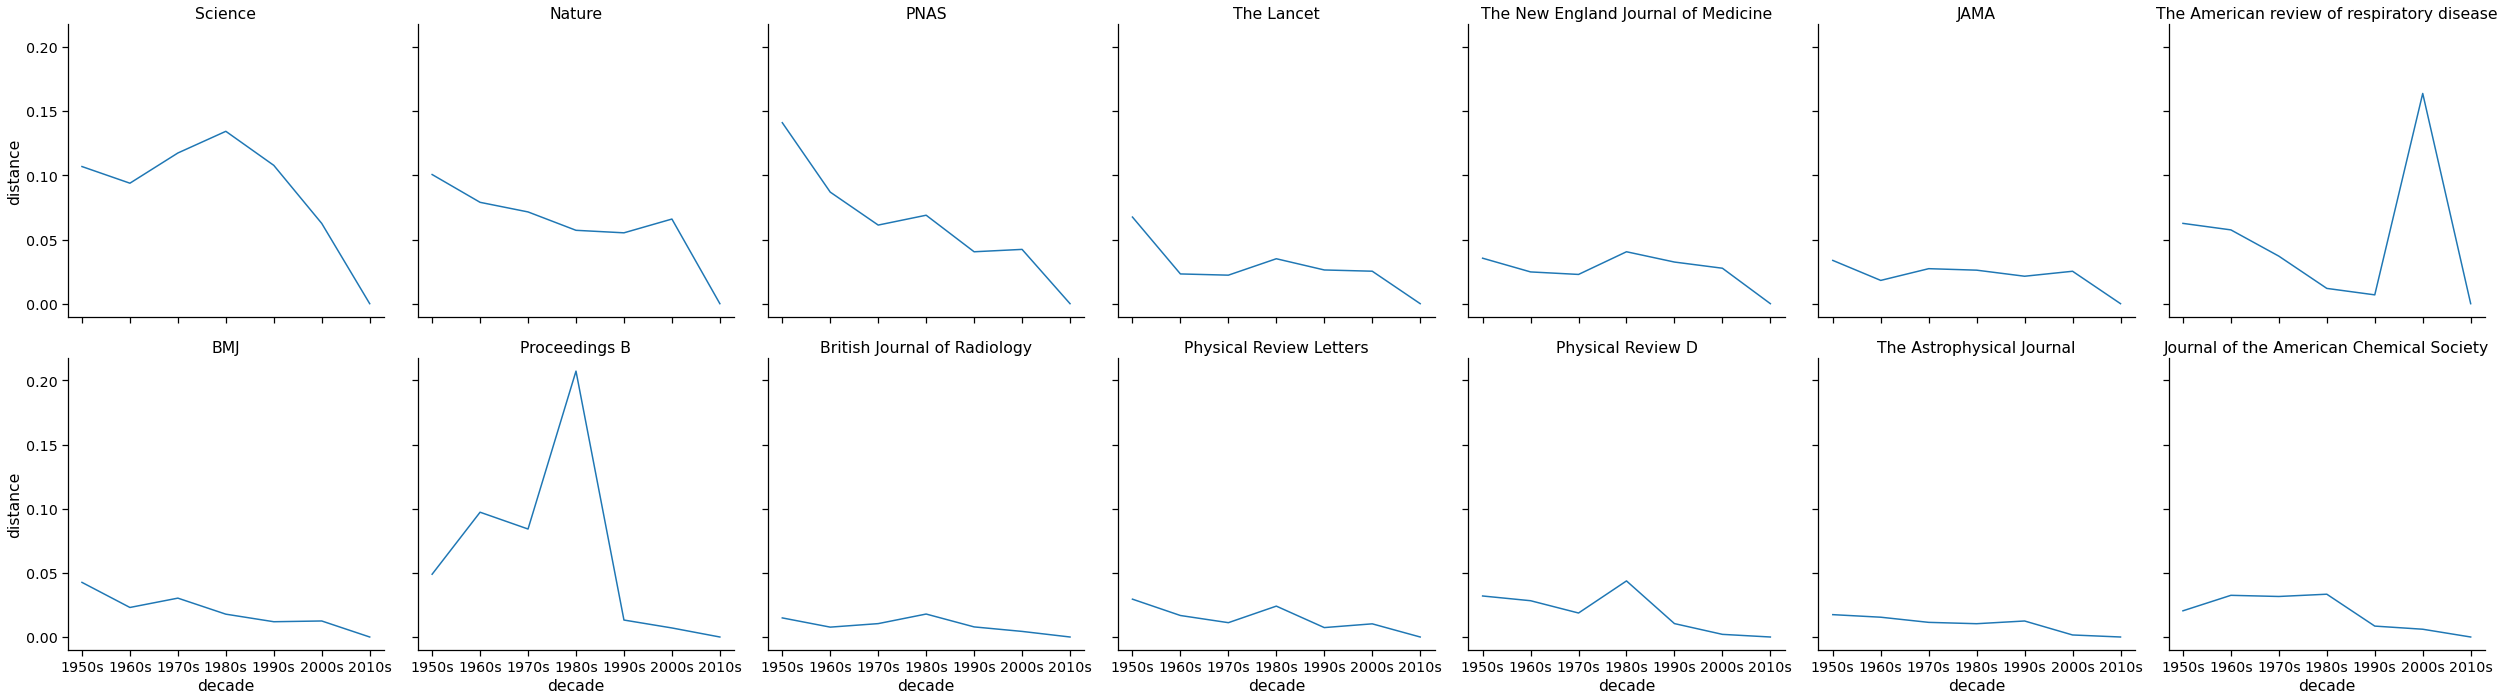

In [20]:
periodical_list = ['Science', 'Nature', 'Proceedings of the National Academy of Sciences of the United States of America',
                                
                   'The Lancet', 'The New England Journal of Medicine', 'JAMA', 'The American review of respiratory disease', 'BMJ', 
                                
                   'Proceedings of The Royal Society B: Biological Sciences', 'British Journal of Radiology', 'Physical Review Letters', 
                   'Physical Review D', 'The Astrophysical Journal',

                   'Journal of the American Chemical Society'
                  ]

neighbor_dist_df_wide = pd.wide_to_long(neighbor_dist_df,
                             stubnames=['neighbor_distance'],
                             suffix='.+',
                             sep='_',
                             i = ['VID', 'venue_name'],
                             j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(data=neighbor_dist_df_wide,
                     x='decade', y='neighbor_distance',
                     legend=False,
                     col='venue_name', col_wrap=7, 
                     col_order=periodical_list,
                     kind='line')
    
    g.set_titles("{col_name}")
    g.axes[2].set_title('PNAS')
    g.axes[8].set_title('Proceedings B')
    g.set_ylabels('distance')

In [ ]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
g.savefig('/media/sdb/p2v/figs/test.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

<Figure size 1800x1200 with 0 Axes>

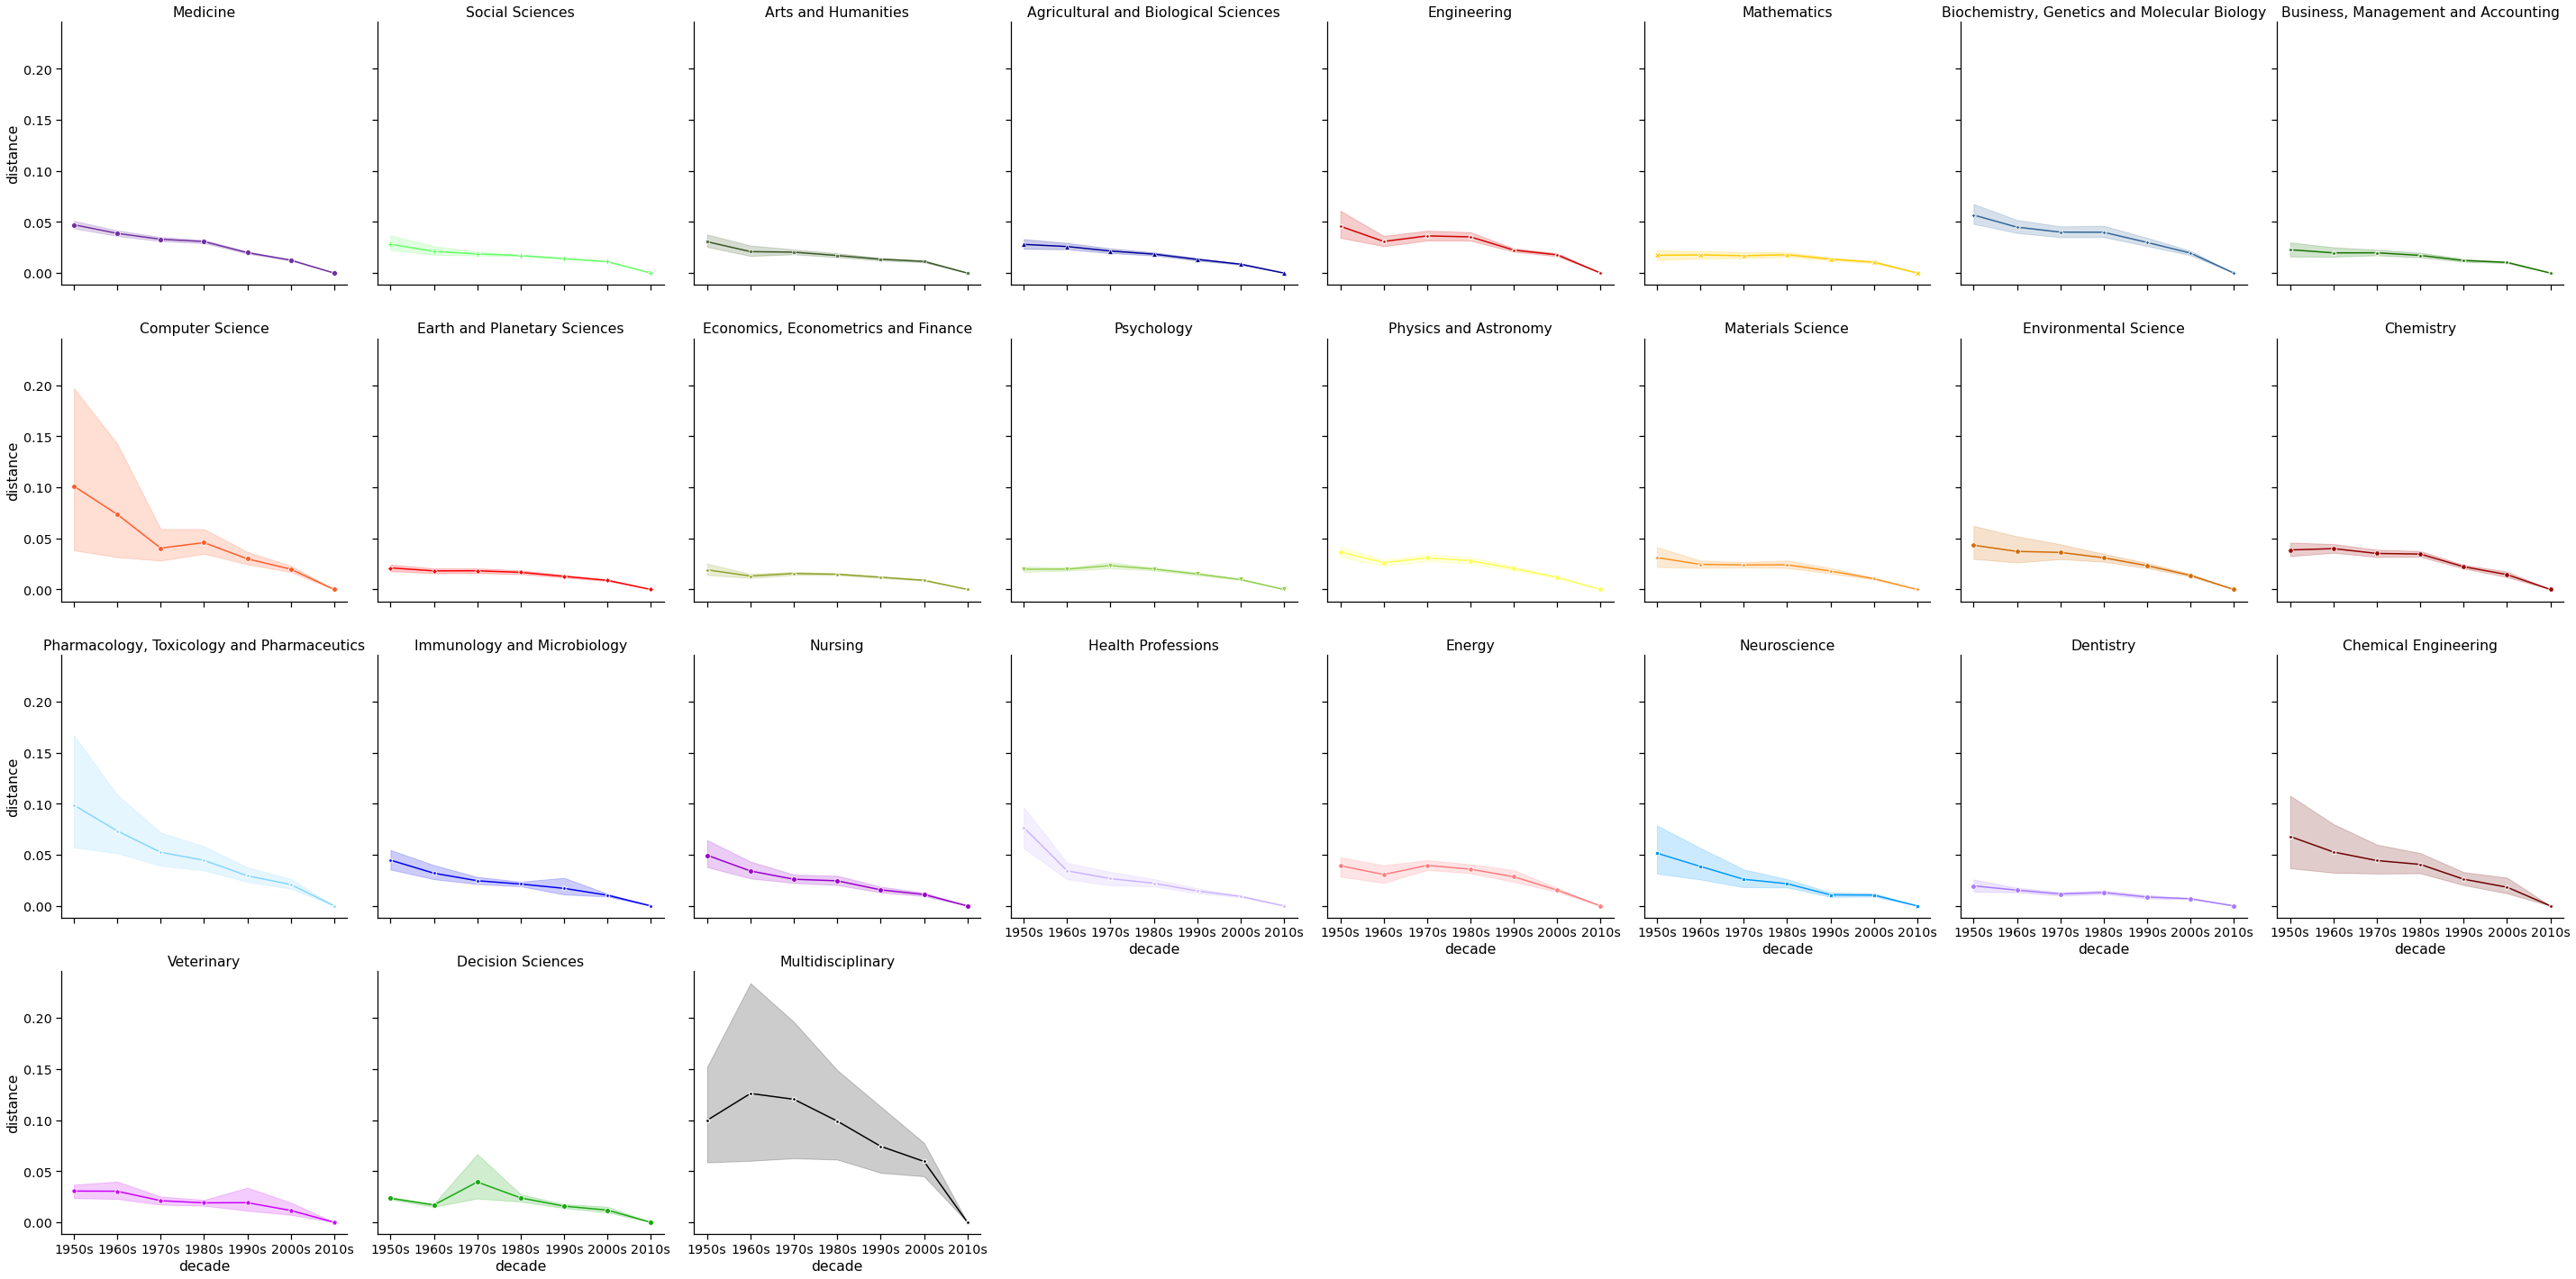

In [20]:
neighbor_dist_df_wide = pd.wide_to_long(neighbor_dist_df,
                             stubnames=['distance'],
                             suffix='.+',
                             sep='_',
                             i = ['VID', 'venue_name'],
                             j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    ax = sns.relplot(data=neighbor_dist_df_wide,
                     x='decade', y='distance',
                     markers=True, dashes=False, style='scopus_label', hue='scopus_label', palette=model.discipline2color,
                     legend=False,
                     col='scopus_label', col_wrap=8, 
                     col_order=['Medicine', 'Social Sciences', 'Arts and Humanities',
                                'Agricultural and Biological Sciences', 'Engineering', 'Mathematics',
                                'Biochemistry, Genetics and Molecular Biology',
                                'Business, Management and Accounting', 'Computer Science',
                                'Earth and Planetary Sciences', 'Economics, Econometrics and Finance',
                                'Psychology', 'Physics and Astronomy', 'Materials Science',
                                'Environmental Science', 'Chemistry',
                                'Pharmacology, Toxicology and Pharmaceutics',
                                'Immunology and Microbiology', 'Nursing', 'Health Professions',
                                'Energy', 'Neuroscience', 'Dentistry', 'Chemical Engineering',
                                'Veterinary', 'Decision Sciences', 'Multidisciplinary'],
                     kind='line')
    ax.set_titles("{col_name}")
    ax.set_ylabels('distance')

In [21]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
ax.savefig('/media/sdb/p2v/figs/28_discipline_semantic_change.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# 2.2 Using change point detection

In [8]:
def get_z_score_dict(dist_dict):
    """
    Convert the dictionary of distance scores for a given timestep into a dictionary of z-scores - i.e. how many standard deviations is a given word's distance score from the mean of all word's distance scores at this timestep?
    """

    # calculate mean and variance of change scores, ignoring any words for whom the value was None -- calculate the mean and variance of the change scores for all words which are represented in both the current timestep's model and the comparison reference model.
    mean = np.mean(list(dist_dict.values()))
    var = np.var(list(dist_dict.values()))

    z_score_dict = {}
    for VID in dist_dict:
        if var == 0:
            z_score_dict[VID] = 0
        else:
            z_score_dict[VID] = (dist_dict[VID] - mean) / np.sqrt(var)

    return z_score_dict

def compute_mean_shift(time_series_dict, j, compare_to):
	"""
	Compute the mean_shift score at index j of the given time-series.
	"""

	timestep_to_index = {}
	for (i,timestep) in enumerate(sorted(time_series_dict.keys())):
		timestep_to_index[timestep] = i

	xs = list(itertools.chain.from_iterable([timestep_to_index[timestep]]*len(time_series_dict[timestep]) for timestep in time_series_dict))
	ys = list(itertools.chain.from_iterable(time_series_dict.values()))

	
	if compare_to == 'first':
		return np.mean([ys[i] for i in range(len(ys)) if xs[i] > j])  - np.mean([ys[i] for i in range(len(ys)) if xs[i] <= j])
	else: # compare_to == 'last' or compare_to == 'previous':
		return np.mean([ys[i] for i in range(len(ys)) if xs[i] <= j])  - np.mean([ys[i] for i in range(len(ys)) if xs[i] > j])


def get_mean_shift_series(time_series_dict, compare_to):
	"""
	Compute a given word's mean_shift time-series from its time-series of z-scores. 
	"""
	return [compute_mean_shift(time_series_dict, j, compare_to) for j in range(len(time_series_dict.keys())-1)]


def get_p_value_series(word, mean_shift_series, n_samples, z_scores_dict, compare_to):
	"""
	Randomly permute the z-score time series n_samples times, and for each
	permutation, compute the mean-shift time-series of those permuted z-scores, and at each index, check if the mean-shift score from the permuted series is greater than the mean-shift score from the original series. The p-value is the proportion of randomly permuted series which yielded a mean-shift score greater than the original mean-shift score.
	"""
	p_value_series = np.zeros(len(mean_shift_series))
	for i in range(n_samples):
		permuted_z_score_series = np.random.permutation(list(z_scores_dict.values()))
		permuted_z_scores_dict = {}
		for (i,z_scores) in enumerate(permuted_z_score_series):
			permuted_z_scores_dict[i] = z_scores
		mean_shift_permuted_series = get_mean_shift_series(permuted_z_scores_dict, compare_to)

		for x in range(len(mean_shift_permuted_series)):
			if mean_shift_permuted_series[x] > mean_shift_series[x]:
				p_value_series[x] += 1
	p_value_series /= n_samples
	return p_value_series


def detect_change_point(word, z_scores_dict, n_samples, p_value_threshold, gamma_threshold, compare_to):
	"""
	This function computes the mean-shift time-series from the given word's z-score series, then computes the p-value series, 
	"""

	index_to_timestep = {}
	for (i,timestep) in enumerate(sorted(z_scores_dict.keys())):
		index_to_timestep[i] = timestep

	mean_shift_series = get_mean_shift_series(z_scores_dict, compare_to)
	p_value_series = get_p_value_series(word, mean_shift_series, n_samples, z_scores_dict, compare_to)

	# set p-values for any time-slices with average z-scores below gamma threshold to 1, so that these time-slices won't get chosen. 
	for i in range(len(p_value_series)):
		if np.mean(z_scores_dict[index_to_timestep[i]]) < gamma_threshold:
			p_value_series[i] = 1

	# find minimum p_value:
	p_value_series = np.array(p_value_series)
	try:
		min_p_val = p_value_series.min()
	except ValueError:
		print(word)
		print(z_scores_dict)
		print(mean_shift_series)
		print(p_value_series)
    
	# if minimum p_value is below the threshold:
	if min_p_val < p_value_threshold:

		# get indices of time-slices with minimum p_value:
		indices = np.where(p_value_series == min_p_val)[0]

		# as a tie-breaker, return the one which corresponds to the biggest mean_shift
		(change_point, mean_shift) = max([(i, mean_shift_series[i]) for i in indices], key = lambda x:x[1])

		z_score = np.mean(z_scores_dict[index_to_timestep[change_point]])
		time_slice_label = index_to_timestep[change_point]
        
		return (word, time_slice_label, min_p_val, mean_shift, z_score)

	else: 
		return None


def get_word_change_point(tup):
	(word, sim_dict) = tup

	change_point = detect_change_point(word, sim_dict, 
                                       n_samples, p_value_threshold, gamma_threshold, compare_to)
	if change_point:
		return change_point

In [53]:
decade_list = ['1950s',
               '1960s',	
               '1970s',	
               '1980s',	
               '1990s',	
               '2000s']

dist_df = neighbor_dist_df.copy()
dist_df = dist_df.rename(columns={"neighbor_distance_1950s": "1950s", 
                                  "neighbor_distance_1960s": "1960s",
                                  "neighbor_distance_1970s": "1970s",
                                  "neighbor_distance_1980s": "1980s",
                                  "neighbor_distance_1990s": "1990s",
                                  "neighbor_distance_2000s": "2000s"
                                  })
dist_df.set_index('venue_name', inplace=True)

# indicate the fisrt decade to start
i = 0
dict_of_dist_dicts = dist_df[decade_list[i:]].dropna().to_dict()

In [ ]:
dict_of_z_score_dicts = {}
for t in decade_list[i:]:
    if t in dict_of_dist_dicts:
        dict_of_z_score_dicts[t] = get_z_score_dict(dict_of_dist_dicts[t])

dict_of_dist_by_word = defaultdict(lambda: defaultdict(list))
for time_slice in dict_of_dist_dicts:
    for word in dict_of_dist_dicts[time_slice].keys():
        dict_of_dist_by_word[word][time_slice].append(dict_of_dist_dicts[time_slice][word])

dict_of_z_scores_by_word = defaultdict(lambda: defaultdict(list))
for time_slice in dict_of_z_score_dicts:
    for word in dict_of_z_score_dicts[time_slice].keys():
        dict_of_z_scores_by_word[word][time_slice].append(dict_of_z_score_dicts[time_slice][word])

In [358]:
len(dict_of_dist_by_word)

1153

In [ ]:
n_samples = 1000
p_value_threshold = 0.05
gamma_threshold = 0
compare_to = 'last'

In [194]:
# no standardization

pool = multiprocessing.Pool()
results = pool.map(get_word_change_point, dict_of_dist_by_word.items())
results = [r for r in results if r]

pool.close()
pool.join()

# ranked by mean-shift score first, then by p-value
sorted_results = sorted(results, key=lambda x:-x[3])
sorted_results = sorted(sorted_results, key=lambda x:x[2])

In [197]:
# with standardization

pool = multiprocessing.Pool()
results = pool.map(get_word_change_point, dict_of_z_scores_by_word.items())
results = [r for r in results if r]

pool.close()
pool.join()

# ranked by mean-shift score first, then by p-value
sorted_results = sorted(results, key=lambda x:-x[3])
sorted_results = sorted(sorted_results, key=lambda x:x[2])

In [198]:
cp_df = pd.DataFrame.from_records(sorted_results, columns =['venue_name', 
                                                            'change_point', 
                                                            'p_value', 
                                                            'mean_shift_score', 
                                                            'z_score'])

In [ ]:
cp_df.head(20)

In [18]:
def get_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = current_wv.most_similar(positive=VID, topn=3)
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]

top20_df = cp_df.head(20).copy()

for i in range(0, 7):
    current_wv = model.load_wv(start_year_list[i], end_year_list[i], 100, 10)
    top20_df['neighbor_'+start_year_list[i]+'s'] = top20_df['venue_name'].parallel_apply(get_neighbor)
    

2023-09-04 09:27:16 -- start loading word vectors...
2023-09-04 09:27:16 -- word vectors loaded, and its shape is: (701, 100)
2023-09-04 09:27:17 -- start loading word vectors...
2023-09-04 09:27:17 -- word vectors loaded, and its shape is: (1499, 100)
2023-09-04 09:27:18 -- start loading word vectors...
2023-09-04 09:27:18 -- word vectors loaded, and its shape is: (2942, 100)
2023-09-04 09:27:18 -- start loading word vectors...
2023-09-04 09:27:18 -- word vectors loaded, and its shape is: (5241, 100)
2023-09-04 09:27:19 -- start loading word vectors...
2023-09-04 09:27:19 -- word vectors loaded, and its shape is: (9021, 100)
2023-09-04 09:27:20 -- start loading word vectors...
2023-09-04 09:27:20 -- word vectors loaded, and its shape is: (16449, 100)
2023-09-04 09:27:21 -- start loading word vectors...
2023-09-04 09:27:21 -- word vectors loaded, and its shape is: (26968, 100)


In [19]:
top20_df

,venue_name,change_point,p_value,mean_shift_score,z_score,neighbor_1950s,neighbor_1960s,neighbor_1970s,neighbor_1980s,neighbor_1990s,neighbor_2000s,neighbor_2010s
0,British Medical Bulletin,2000s,0.0,4.416168,7.193458,"[Experimental Physiology, Clinical Science, The Practitioner]","[Experimental Physiology, Clinical Science, Presse Medicale]","[Transactions of the American Neurological Association, Neurology, Advances in Neurology]","[East African Medical Journal, The Lancet, Annals of clinical research]","[The Lancet, The Japanese journal of experimental medicine, BMJ]","[The Lancet, Tidsskrift for Den Norske Laegeforening, South African Medical Journal]","[Revista Chilena de Ortopedia y Traumatología, Medicina-buenos Aires, BMC Medicine]"
1,Proceedings of the National Academy of Sciences of the United States of America,1950s,0.0,4.044555,5.363306,"[Annals of Mathematics, Nagoya Mathematical Journal, Journal D Analyse Mathematique]","[Progress in Nucleic Acid Research and Molecular Biology, Journal of Molecular Biology, Michigan Mathematical Journal]","[Cold Spring Harbor Symposia on Quantitative Biology, Biochemical and Biophysical Research Communications, Journal of Biological Chemistry]","[Cold Spring Harbor Symposia on Quantitative Biology, The EMBO Journal, Cell]","[The EMBO Journal, Cell, Journal of Biological Chemistry]","[PLOS Biology, PLOS ONE, Nature]","[Science Advances, Science, Nature Communications]"
2,Zeitschrift für Naturforschung B,1970s,0.0,3.608512,3.497999,"[Biological Chemistry, Zeitschrift für Physikalische Chemie, Journal of Biochemistry]","[Journal of the American Chemical Society, Biological Chemistry, Macromolecular Chemistry and Physics]","[Zeitschrift für Naturforschung C, Journal of the American Chemical Society, Acta Chemica Scandinavica]","[Inorganic Chemistry, Angewandte Chemie, Zeitschrift für Naturforschung C]","[Zeitschrift für anorganische und allgemeine Chemie, Angewandte Chemie, Chemische Berichte]","[Zeitschrift Fur Kristallographie-new Crystal Structures, Polish Journal of Chemistry, Helvetica Chimica Acta]","[Journal of Chemical Crystallography, Zeitschrift für anorganische und allgemeine Chemie, Zeitschrift Fur Kristallographie-new Crystal Structures]"
3,Naturwissenschaften,1990s,0.0,3.366414,1.571852,"[Angewandte Chemie, Nature, Journal of Plant Nutrition and Soil Science]","[Flora oder Allgemeine Botanische Zeitung, Angewandte Chemie, Planta Medica]","[Zeitschrift für Naturforschung C, Biologie in Unserer Zeit, Zeitschrift für Naturforschung B]","[Zeitschrift für Naturforschung C, Insectes Sociaux, Facies]","[Entomologia Generalis, Ethology Ecology & Evolution, Insectes Sociaux]","[Insectes Sociaux, Ethology Ecology & Evolution, Biology Letters]","[Biological Journal of The Linnean Society, Frontiers in Zoology, Journal of Zoology]"
4,American Journal of Epidemiology,1960s,0.0,3.235472,3.278905,"[American Journal of Tropical Medicine and Hygiene, Journal of Immunology, Bulletin of The World Health Organization]","[Acta Virologica, Journal of Immunology, A.M.A. journal of diseases of children]","[International Journal of Epidemiology, HSMHA health reports, Journal of Chronic Diseases]","[International Journal of Epidemiology, Epidemiologic Reviews, American Journal of Public Health]","[Epidemiology, International Journal of Epidemiology, Epidemiologic Reviews]","[Annals of Epidemiology, International Journal of Epidemiology, Epidemiology]","[Epidemiology, Annals of Epidemiology, European Journal of Epidemiology]"
5,International Journal of Legal Medicine,1970s,0.0,3.162425,4.763518,"[Annals of Hematology, Research in Experimental Medicine, Journal of Neurology]","[Annals of Hematology, Archiv für Psychiatrie und Nervenkrankheiten, vereinigt mit Zeitschrift für die gesamte Neurologie und Psychiatrie, Medicine Science and The Law]","[Forensic Science, Medicine Science and The Law, Journal of Forensic Sciences]","[Forensic Science International, Journal of Forensic Sciences, Medicine 

<Figure size 12000x9000 with 0 Axes>

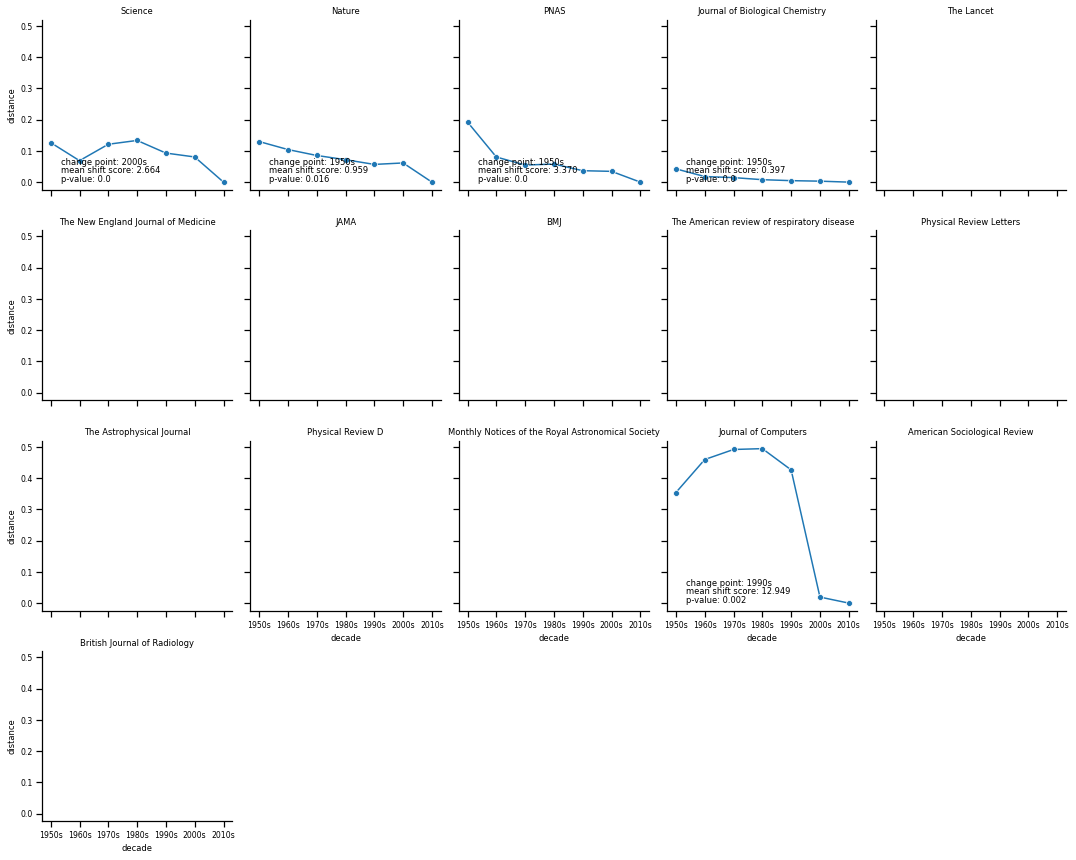

In [282]:
def annotate(data, **kws):
    change_point = data.index[0][1]
    mean_shift_score = data.index[0][2]
    p_value = data.index[0][3]
    ax = plt.gca()
    ax.text(.1, .15, f"change point: {change_point}", transform=ax.transAxes)
    ax.text(.1, .10, f"mean shift score: {format((mean_shift_score), '.3f')}", transform=ax.transAxes)
    ax.text(.1, .05, f"p-value: {p_value}", transform=ax.transAxes)

periodical_list = ['Science', 'Nature', 
                   'Proceedings of the National Academy of Sciences of the United States of America', 
                   'Journal of Biological Chemistry', 
                                
                   'The Lancet', 'The New England Journal of Medicine', 'JAMA', 'BMJ',
                   'The American review of respiratory disease',
                                
                   'Physical Review Letters', 'The Astrophysical Journal', 'Physical Review D', 
                   'Monthly Notices of the Royal Astronomical Society',

                   'American Sociological Review',
                   'British Journal of Radiology'
                  ]

overall_distance_df_wide = pd.wide_to_long(cp_df[cp_df.venue_name.isin(periodical_list)].merge(overall_distance_df[overall_distance_df.venue_name.isin(periodical_list)],
                                                    on='venue_name'
                                                   ),
                                                  stubnames=['distance'],
                                                  suffix='.+',
                                                  sep='_',
                                                  i = ['VID', 'change_point', 'mean_shift_score', 'p_value', 'z_score'],
                                                  j = 'decade')

plt.figure(figsize=(40, 30),dpi=300)
with sns.plotting_context("notebook", font_scale=0.7):
    # g = sns.relplot(data=overall_neighbor_change_df_wide,
                     # x='decade', y='local_neighborhood_change',
                     # markers=True, dashes=False, style='venue_name', hue='venue_name',
                     # legend=False,
                     # col='venue_name', col_wrap=5, 
                     # col_order=periodical_list,
                     # kind='line')
    g = sns.FacetGrid(overall_distance_df_wide, col="venue_name", col_wrap=5, col_order=periodical_list)
    g.map_dataframe(sns.lineplot, x='decade', y='distance',
                     markers=True, dashes=False, style='venue_name', hue='venue_name',
                     legend=False,)
    g.map_dataframe(annotate)
    g.set_titles("{col_name}")
    g.axes[2].set_title('PNAS')
    # ax.axes[12].set_title('ACL')
    g.set_ylabels('distance')

plt.show()

In [616]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
g.savefig('/media/sdb/p2v/figs/change_point.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# 2.3 decade by decade

In [12]:
def get_old_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = old_wv.most_similar(positive=VID, topn=k_list[i])
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]
def get_new_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = new_wv.most_similar(positive=VID, topn=k_list[i+1])
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]
def get_old_res_neighbor(x):
    res_neighbor_list = [neighbor for neighbor in x['neighbor_'+start_year_list[i]+'s'] 
                         if neighbor not in x['neighbor_'+start_year_list[i+1]+'s']]
    return res_neighbor_list[0:3]
def get_new_res_neighbor(x):
    res_neighbor_list = [neighbor for neighbor in x['neighbor_'+start_year_list[i+1]+'s'] 
                         if neighbor not in x['neighbor_'+start_year_list[i]+'s']]
    return res_neighbor_list[0:3]

k_list = [5, 7, 14, 17, 9, 17, 28]

for i in range (0, 6):
    old_wv = model.load_wv(start_year_list[i], end_year_list[i], 100, 10)
    new_wv = model.load_wv(start_year_list[i+1], end_year_list[i+1], 100, 10)
    
    intersection_df = dist_df[['VID',start_year_list[i]+'s', start_year_list[i+1]+'s', 'venue_name', 'scopus_label']].dropna()
    intersection_df['difference'] = intersection_df[start_year_list[i]+'s'] - intersection_df[start_year_list[i+1]+'s']
    
    intersection_df['neighbor_'+start_year_list[i]+'s'] = intersection_df['venue_name'].parallel_apply(get_old_neighbor)
    intersection_df['neighbor_'+start_year_list[i+1]+'s'] = intersection_df['venue_name'].parallel_apply(get_new_neighbor)
    
    intersection_df['res_neighbor_'+start_year_list[i]+'s'] = intersection_df.parallel_apply(get_old_res_neighbor, axis=1)
    intersection_df['res_neighbor_'+start_year_list[i+1]+'s'] = intersection_df.parallel_apply(get_new_res_neighbor, axis=1)
    
    display(intersection_df.sort_values('difference', ascending=False).head(10)[['venue_name', 
                                                                                 'scopus_label', 
                                                                                 'difference',
                                                                                 'res_neighbor_'+start_year_list[i]+'s',
                                                                                 'res_neighbor_'+start_year_list[i+1]+'s'
                                                                                ]])

2023-09-05 14:00:23 -- start loading word vectors...
2023-09-05 14:00:23 -- word vectors loaded, and its shape is: (701, 100)
2023-09-05 14:00:23 -- start loading word vectors...
2023-09-05 14:00:23 -- word vectors loaded, and its shape is: (1499, 100)


,venue_name,scopus_label,difference,res_neighbor_1950s,res_neighbor_1960s
279,Proceedings of the National Academy of Sciences of the United States of America,Multidisciplinary,0.089846,"[Annals of Mathematics, Nagoya Mathematical Journal, Journal D Analyse Mathematique]","[Progress in Nucleic Acid Research and Molecular Biology, Journal of Molecular Biology, Michigan Mathematical Journal]"
249,Radiation Research,Medicine,0.066169,"[Journal of Cellular and Comparative Physiology, The International Journal of Applied Radiation and Isotopes, Physics in Medicine and Biology]","[International Journal of Radiation Biology, Advances in biological and medical physics, Mutation Research]"
543,Immunology and Cell Biology,Immunology and Microbiology,0.055319,"[Veterinary Record, Annales de l'Institut Pasteur]","[Australian Journal of Zoology, International Archives of Allergy and Immunology, Australian Veterinary Journal]"
313,European Food Research and Technology,Agricultural and Biological Sciences,0.054082,"[Biological Chemistry, Macromolecular Chemistry and Physics, Journal of Agricultural and Food Chemistry]","[Advances in food research, Plant Foods for Human Nutrition, Journal of the Science of Food and Agriculture]"
534,Journal of Pharmacology and Experimental Therapeutics,"Pharmacology, Toxicology and Pharmaceutics",0.050531,"[Anesthesia & Analgesia, Anesthesiology, A.M.A. archives of pathology]","[Archives internationales de pharmacodynamie et de thérapie, Clinical Pharmacology & Therapeutics, Naunyn-schmiedebergs Archives of Pharmacology]"
513,Journal of the Acoustical Society of America,Physics and Astronomy,0.049465,"[Annales Des Télécommunications, IEEE Transactions on Information Theory, Geophysics]","[Journal of Speech Language and Hearing Research, Journal of Applied Mechanics, Journal of Sound and Vibration]"
178,Deutsche Medizinische Wochenschrift,Medicine,0.049013,[Biological Chemistry],"[Medizinische Klinik, Medizinische Welt, Drug Research]"
417,Clinica Chimica Acta,"Biochemistry, Genetics and Molecular Biology",0.048523,"[Methods in Enzymology, Annals of Hematology, Journal of Chromatography A]","[Clinical Chemistry, Clinical Chemistry and Laboratory Medicine, Analytical Biochemistry]"
49,Archives of Physiology and Biochemistry,Medicine,0.048275,"[Journal of Insect Physiology, Psychiatry and Clinical Neurosciences, Journal of Cellular and Comparative Physiology]","[Japanese Journal of Physiology, Bulletin of Experimental Biology and Medicine, Life Sciences]"
541,Naturwissenschaften,Agricultural and Biological Sciences,0.047407,[Journal of Plant Nutrition and Soil Science],"[Planta Medica, Cellular and Molecular Life Sciences, Planta]"


2023-09-05 14:00:49 -- start loading word vectors...
2023-09-05 14:00:49 -- word vectors loaded, and its shape is: (1499, 100)
2023-09-05 14:00:49 -- start loading word vectors...
2023-09-05 14:00:49 -- word vectors loaded, and its shape is: (2942, 100)


,venue_name,scopus_label,difference,res_neighbor_1960s,res_neighbor_1970s
1,Wsq: Women's Studies Quarterly,Social Sciences,0.117526,"[New Zealand Journal of Marine and Freshwater Research, Ices Journal of Marine Science, Ophelia]","[The Progressive Fish-culturist, Journal of Fish Biology, Environmental Biology of Fishes]"
688,Journal of Computers,Computer Science,0.105501,"[Annual Review of Physical Chemistry, Journal of Polymer Science Part B: Polymer Letters, Journal of Polymer Science]","[Journal of the Chemical Society, Faraday Transactions, Chemical Society Reviews, Collection of Czechoslovak Chemical Communications]"
665,Endeavour,Arts and Humanities,0.087282,"[Plant and Cell Physiology, Tetrahedron, Planta Medica]","[Bulletin De La Societe Geologique De France, Grana, International Journal of Nautical Archaeology]"
815,Cryobiology,Medicine,0.077253,"[Advances in Applied Microbiology, Journal of Biomedical Materials Research, Journal of Cellular Physiology]","[Cryogenics, Journal of Thermal Biology, The Journal of Dermatologic Surgery and Oncology]"
994,BioSystems,Mathematics,0.073771,"[Journal of Cellular Physiology, Biochemical and Biophysical Research Communications, Progress in Nucleic Acid Research and Molecular Biology]","[Origins of Life and Evolution of Biospheres, Molecular and Cellular Biochemistry, Plant Systematics and Evolution]"
804,IEEE Transactions on Education,Social Sciences,0.072200,"[IEEE Transactions on Aerospace and Electronic Systems, IEEE Transactions on Aerospace, IEEE Journal of Solid-state Circuits]","[Innovations in Education and Training International, Improving College and University Teaching, Educational Technology archive]"
498,Scientific American,Multidisciplinary,0.056835,"[Technology and Culture, Geographical Review, Geriatrics]","[Minerva, Psyccritiques, Social Studies of Science]"
2,American Journal of Epidemiology,Medicine,0.053960,"[Acta Virologica, Journal of Immunology, A.M.A. journal of diseases of children]","[International Journal of Epidemiology, HSMHA health reports, Journal of Chronic Diseases]"
1087,Pathobiology,Medicine,0.053328,"[Pharmacology, Deutsche Medizinische Wochenschrift, Presse Medicale]","[The Japanese journal of experimental medicine, American Journal of Pathology, Laboratory Investigation]"
50,Journal of Cell Science,"Biochemistry, Genetics and Molecular Biology",0.052201,"[Cell and Tissue Research, Journal of Morphology, Zoological Journal of the Linnean Society]","[Developmental Biology, Experimental Cell Research, Protoplasma]"


2023-09-05 14:01:30 -- start loading word vectors...
2023-09-05 14:01:30 -- word vectors loaded, and its shape is: (2942, 100)
2023-09-05 14:01:30 -- start loading word vectors...
2023-09-05 14:01:30 -- word vectors loaded, and its shape is: (5241, 100)


,venue_name,scopus_label,difference,res_neighbor_1970s,res_neighbor_1980s
1105,Radiation and Environmental Biophysics,Medicine,0.070230,"[Biophysical Journal, The Journal of Membrane Biology, Radiation Botany]","[Advances in radiation biology, Journal of Radiation Research, International Journal of Hyperthermia]"
1406,Physical Therapy,Health Professions,0.068728,"[New York state journal of medicine, Southern Medical Journal, Dental Clinics of North America]","[Journal of Orthopaedic & Sports Physical Therapy, Clinical Rehabilitation, Occupational Therapy Journal of Research]"
473,Zeitschrift für Naturforschung B,Chemistry,0.066947,"[Naturwissenschaften, European Journal of Organic Chemistry, Plant and Cell Physiology]","[Inorganic Chemistry, Angewandte Chemie, Journal of The Chemical Society-dalton Transactions]"
508,Physica D: Nonlinear Phenomena,Physics and Astronomy,0.063709,"[Physica B-condensed Matter, Physica A-statistical Mechanics and Its Applications, Physical Review A]","[Japan Journal of Applied Mathematics, Journal of Statistical Physics, Publications Mathématiques de l'IHÉS]"
840,Chemistry and Technology of Fuels and Oils,Energy,0.063638,"[Polymer Science U.s.s.r., Tribology International, Fibre Chemistry]","[Petroleum Science and Technology, Fuel Processing Technology, Journal of The Japan Petroleum Institute]"
382,Optometry and Vision Science,Medicine,0.051595,"[Transactions. Section on Ophthalmology. American Academy of Ophthalmology and Otolaryngology, The Australian Journal of Optometry, Transactions - American Academy of Ophthalmology and Otolaryngology]","[Ophthalmic and Physiological Optics, Journal of The British Contact Lens Association, Clinical and Experimental Optometry]"
687,Ultrasonics,Physics and Astronomy,0.049877,"[Non-destructive Testing, Journal of Clinical Ultrasound, Physical Acoustics]","[IEEE Transactions on Ultrasonics Ferroelectrics and Frequency Control, international symposium on electrets, Journal of Nondestructive Evaluation]"
2316,Computers & Graphics,Computer Science,0.041965,"[design automation conference, Advances in Computers, international symposium on computer architecture]","[The Visual Computer, eurographics, Computer Graphics Forum]"
1390,Gerontology,Medicine,0.041397,"[Physiological Research, Laboratory Investigation, Biomedicine]","[Age and Ageing, Archives of Gerontology and Geriatrics, Journal of the American Geriatrics Society]"
518,International Journal of Legal Medicine,Medicine,0.041083,"[Forensic Science, Zeitschrift für Immunitätsforschung: Immunobiology, Human Genetics]","[Forensic Science International, Electrophoresis, Journal of the Canadian Society of Forensic Science]"


2023-09-05 14:02:41 -- start loading word vectors...
2023-09-05 14:02:41 -- word vectors loaded, and its shape is: (5241, 100)
2023-09-05 14:02:41 -- start loading word vectors...
2023-09-05 14:02:41 -- word vectors loaded, and its shape is: (9021, 100)


,venue_name,scopus_label,difference,res_neighbor_1980s,res_neighbor_1990s
502,Protein Science,"Biochemistry, Genetics and Molecular Biology",0.203282,"[Classical and Quantum Gravity, Few-body Systems, Theoretical and Mathematical Physics]","[Nature Structural & Molecular Biology, Structure, Current Opinion in Structural Biology]"
665,Endeavour,Arts and Humanities,0.174547,"[Journal of the Marine Biological Association of the United Kingdom, Journal of Molluscan Studies, Advances in Ecological Research]","[The British Journal for the History of Science, Chemical Society Reviews, Studies in Conservation]"
553,Proceedings of The Royal Society B: Biological Sciences,Agricultural and Biological Sciences,0.115280,"[alvey vision conference, computer vision and pattern recognition, Visual Neuroscience]","[Trends in Ecology and Evolution, Behavioral Ecology, Ecological Entomology]"
3242,Lasers in Medical Science,Medicine,0.099820,"[Seminars in Surgical Oncology, Journal of Gynecologic Surgery, Microsurgery]","[THE JOURNAL OF JAPAN SOCIETY FOR LASER SURGERY AND MEDICINE, Biosilico, Journal of Clinical Laser Medicine & Surgery]"
3111,Pharmacy World & Science,Medicine,0.086183,"[Clinical Pharmacokinectics, Pharmaceutical Research, Biopharmaceutics & Drug Disposition]","[Drug Safety, Journal of Pharmacy Practice, Clinical Drug Investigation]"
688,Journal of Computers,Computer Science,0.085755,"[Faraday Discussions of The Chemical Society, Israel Journal of Chemistry, Inorganic Chemistry]","[Russian Journal of Physical Chemistry A, Kinetics and Catalysis, Physics and Chemistry of Glasses]"
2439,International Journal of Rehabilitation Research,Medicine,0.083329,"[Mental Retardation, American journal of mental deficiency, Scandinavian Journal of Behaviour Therapy]","[Journal of Rehabilitation, Rehabilitation Counseling Bulletin, Scandinavian Journal of Rehabilitation Medicine]"
642,Health Physics,Medicine,0.077280,"[Journal of The Society for Radiological Protection, Environment International, Environment]","[Annals of The Icrp, Journal of Radiological Protection, Radioprotection]"
2039,In Vitro Cellular & Developmental Biology – Plant,"Biochemistry, Genetics and Molecular Biology",0.076680,"[Journal of Tissue Culture Methods, Cell Biology International Reports, Journal of Cellular Physiology]","[In Vitro Cellular & Developmental Biology – Animal, Plant Cell Tissue and Organ Culture, Transgenic Research]"
2626,Industrial Health,Medicine,0.074605,"[Toxicology Letters, Archives of Toxicology, Developments in toxicology and environmental science]","[Journal of Occupational Health, Occupational Medicine, International Journal of Occupational Safety and Ergonomics]"


2023-09-05 14:04:40 -- start loading word vectors...
2023-09-05 14:04:40 -- word vectors loaded, and its shape is: (9021, 100)
2023-09-05 14:04:40 -- start loading word vectors...
2023-09-05 14:04:41 -- word vectors loaded, and its shape is: (16449, 100)


,venue_name,scopus_label,difference,res_neighbor_1990s,res_neighbor_2000s
688,Journal of Computers,Computer Science,0.372293,"[The Journal of Physical Chemistry, Journal of the Chemical Society, Faraday Transactions, Russian Journal of Physical Chemistry A]","[annual acis international conference on computer and information science, international conference on innovative computing, information and control, networked computing and advanced information management]"
2364,Sozial-und Praventivmedizin,Medicine,0.165467,"[Journal of Epidemiology and Community Health, Scandinavian journal of social medicine, European Journal of General Practice]","[BMC Public Health, International Journal of Public Health, Public Health]"
4687,Applied Immunohistochemistry & Molecular Morphology,Medicine,0.139115,"[Annals of Allergy Asthma & Immunology, Revue Francaise D Allergologie Et D Immunologie Clinique, Journal of Asthma]","[Modern Pathology, The American Journal of Surgical Pathology, Histopathology]"
6979,Journal of X-ray Science and Technology,Medicine,0.078323,"[Laser and Particle Beams, Journal of Optics, Review of Scientific Instruments]","[Medical Physics, International Journal of Biomedical Imaging, ieee nuclear science symposium]"
3623,Stem Cells,Medicine,0.076416,"[Blood, Leukemia, Leukemia & Lymphoma]","[Stem Cells and Development, Stem Cell Reviews and Reports, Cytotherapy]"
5775,Biomedical and Environmental Sciences,Medicine,0.075618,"[IARC scientific publications, Food and Chemical Toxicology, Archives of Environmental Contamination and Toxicology]","[International Journal of Environmental Research and Public Health, Environmental Toxicology and Pharmacology, Toxicological & Environmental Chemistry]"
665,Endeavour,Arts and Humanities,0.074077,"[Chemical Society Reviews, Studies in Conservation, Interdisciplinary Science Reviews]","[Journal of the History of Biology, Studies in History and Philosophy of Science Part C: Studies in History and Philosophy of Biological and Biomedical Sciences, History and Philosophy of The Life Sciences]"
6990,Science News,Engineering,0.070887,"[Chemical & Engineering News, international symposium on technology and society, National Geographic]","[New Scientist, Isis, Bulletin of Science, Technology & Society]"
3838,Pharmazie in Unserer Zeit,Medicine,0.070068,"[European Journal of Drug Metabolism and Pharmacokinetics, Archiv Der Pharmazie, Pharmaceutical Chemistry Journal]","[Clinical Medicine and Therapeutics, Expert Opinion on Pharmacotherapy, Expert Opinion on Therapeutic Targets]"
3912,Interdisciplinary Science Reviews,Arts and Humanities,0.069418,"[Gold Bulletin, Sustainable Development, R & D Management]","[The Monist, Minerva, Science and technology studies]"


2023-09-05 14:07:50 -- start loading word vectors...
2023-09-05 14:07:50 -- word vectors loaded, and its shape is: (16449, 100)
2023-09-05 14:07:50 -- start loading word vectors...
2023-09-05 14:07:50 -- word vectors loaded, and its shape is: (26968, 100)


,venue_name,scopus_label,difference,res_neighbor_2000s,res_neighbor_2010s
11242,Science Progress,Multidisciplinary,0.435723,"[High Pressure Research, The Review of High Pressure Science and Technology, Advances in Microbial Physiology]","[Advances in Mechanical Engineering, Chinese Journal of Mechanical Engineering, Journal of Vibroengineering]"
5986,Hospital Medicine,Veterinary,0.298008,"[British Journal of Hospital Medicine, Journal of the Royal Society of Medicine, Annals of The Royal College of Surgeons of England]","[Tourist Studies, Tourism Geographies, Annals of Tourism Research]"
12810,Versus,Arts and Humanities,0.240161,"[ubiquitous computing, Quarterly of Applied Mathematics, workshop on mobile computing systems and applications]","[Journal of Cultural Economy, Human Studies, Organization Studies]"
9328,International Journal of Pharmaceutical Medicine,"Pharmacology, Toxicology and Pharmaceutics",0.220412,"[Drug Information Journal, Expert Review of Pharmacoeconomics & Outcomes Research, PharmacoEconomics]","[Lc Gc North America, Journal of Pharmaceutical and Biomedical Analysis, Journal of Chinese Pharmaceutical Sciences]"
6990,Science News,Engineering,0.218059,"[New Scientist, Isis, Bulletin of Science, Technology & Society]","[The American Statistician, Significance, Sociological Methods & Research]"
11258,Procedia Chemistry,Chemistry,0.214523,"[ieee sensors, international conference on solid state sensors actuators and microsystems, nano/micro engineered and molecular systems]","[Indonesian Journal of Chemistry, International Journal of Chemical Engineering and Applications, Oriental journal of chemistry]"
9474,Journal of The Korean Chemical Society,Chemical Engineering,0.200360,"[Bulletin of The Korean Chemical Society, Journal of The Chinese Chemical Society, Electrochimica Acta]","[Journal of Digital Convergence, Journal of the Korea Academia Industrial Cooperation Society, Asia-pacific Journal of Multimedia services convergent with Art, Humanities, and Sociology]"
9601,Journal of Health Science,Environmental Science,0.185537,"[Environmental Toxicology and Pharmacology, Bunseki Kagaku, Biological & Pharmaceutical Bulletin]","[Acta Scientiarum. Health Science, International Journal of Health Sciences and Research, Journal of Pharmacy and Bioallied Sciences]"
9915,Biologie Aujourd'hui,"Biochemistry, Genetics and Molecular Biology",0.180826,"[Cellular and Molecular Life Sciences, Russian Journal of Developmental Biology, Seminars in Cell & Developmental Biology]","[Journal of Venomous Animals and Toxins Including Tropical Diseases, Toxicon, Ceylon Medical Journal]"
10663,The Scientific World Journal,Medicine,0.173360,"[International journal of adolescent medicine and health, Journal of Pediatric Urology, Nature Clinical Practice Urology]","[International Scholarly Research Notices, SpringerPlus, BioMed Research International]"
